## 라이브러리 불러오기

In [3]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

data_file = "Canadian_climate_history.csv"
MODEL_SELECTED = "deepant" # Possible Values ['deepant', 'lstmae']
LOOKBACK_SIZE = 10
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data_file = os.path.join(dirname, filename)

## 데이터 불러오기

In [4]:
"""연습용 데이터
- 변수 개수 27개
- 모두 수치형 데이터"""
df = pd.read_csv('Canadian_climate_history.csv')
df.head()

,LOCAL_DATE,MEAN_TEMPERATURE_CALGARY,TOTAL_PRECIPITATION_CALGARY,MEAN_TEMPERATURE_EDMONTON,TOTAL_PRECIPITATION_EDMONTON,MEAN_TEMPERATURE_HALIFAX,TOTAL_PRECIPITATION_HALIFAX,MEAN_TEMPERATURE_MONCTON,TOTAL_PRECIPITATION_MONCTON,MEAN_TEMPERATURE_MONTREAL,...,MEAN_TEMPERATURE_STJOHNS,TOTAL_PRECIPITATION_STJOHNS,MEAN_TEMPERATURE_TORONTO,TOTAL_PRECIPITATION_TORONTO,MEAN_TEMPERATURE_VANCOUVER,TOTAL_PRECIPITATION_VANCOUVER,MEAN_TEMPERATURE_WHITEHORSE,TOTAL_PRECIPITATION_WHITEHORSE,MEAN_TEMPERATURE_WINNIPEG,TOTAL_PRECIPITATION_WINNIPEG
0,01-Jan-1940 00:00:00,-11.4,0.5,NaN,NaN,NaN,NaN,-8.9,0.0,NaN,...,NaN,NaN,-8.9,0.0,8.9,5.8,NaN,NaN,-20.9,0.0
1,02-Jan-1940 00:00:00,-12.0,0.5,NaN,NaN,NaN,NaN,-14.5,0.0,NaN,...,NaN,NaN,-13.1,0.3,9.7,7.1,NaN,NaN,-18.4,0.0
2,03-Jan-1940 00:00:00,-12.0,1.0,NaN,NaN,NaN,NaN,-11.1,0.0,NaN,...,NaN,NaN,-6.1,0.0,7.8,1.0,NaN,NaN,-22.0,0.0
3,04-Jan-1940 00:00:00,-11.4,0.8,NaN,NaN,NaN,NaN,-11.1,0.3,NaN,...,NaN,NaN,-6.4,0.5,8.1,0.5,NaN,NaN,-20.3,0.0
4,05-Jan-1940 00:00:00,-13.1,0.5,NaN,NaN,NaN,NaN,-8.1,0.0,NaN,...,NaN,NaN,-7.2,16.5,7.0,0.8,NaN,NaN,-18.7,0.0


In [5]:
## 결측치 존재
df.isnull().sum()

LOCAL_DATE                           0
MEAN_TEMPERATURE_CALGARY           189
TOTAL_PRECIPITATION_CALGARY        173
MEAN_TEMPERATURE_EDMONTON         7657
TOTAL_PRECIPITATION_EDMONTON      7646
MEAN_TEMPERATURE_HALIFAX          7164
TOTAL_PRECIPITATION_HALIFAX       7226
MEAN_TEMPERATURE_MONCTON          2336
TOTAL_PRECIPITATION_MONCTON       2767
MEAN_TEMPERATURE_MONTREAL          755
TOTAL_PRECIPITATION_MONTREAL       730
MEAN_TEMPERATURE_OTTAWA             76
TOTAL_PRECIPITATION_OTTAWA          81
MEAN_TEMPERATURE_QUEBEC           1214
TOTAL_PRECIPITATION_QUEBEC        1227
MEAN_TEMPERATURE_SASKATOON        2473
TOTAL_PRECIPITATION_SASKATOON     3755
MEAN_TEMPERATURE_STJOHNS           808
TOTAL_PRECIPITATION_STJOHNS        822
MEAN_TEMPERATURE_TORONTO            74
TOTAL_PRECIPITATION_TORONTO         80
MEAN_TEMPERATURE_VANCOUVER          53
TOTAL_PRECIPITATION_VANCOUVER       55
MEAN_TEMPERATURE_WHITEHORSE       1691
TOTAL_PRECIPITATION_WHITEHORSE    4095
MEAN_TEMPERATURE_WINNIPEG

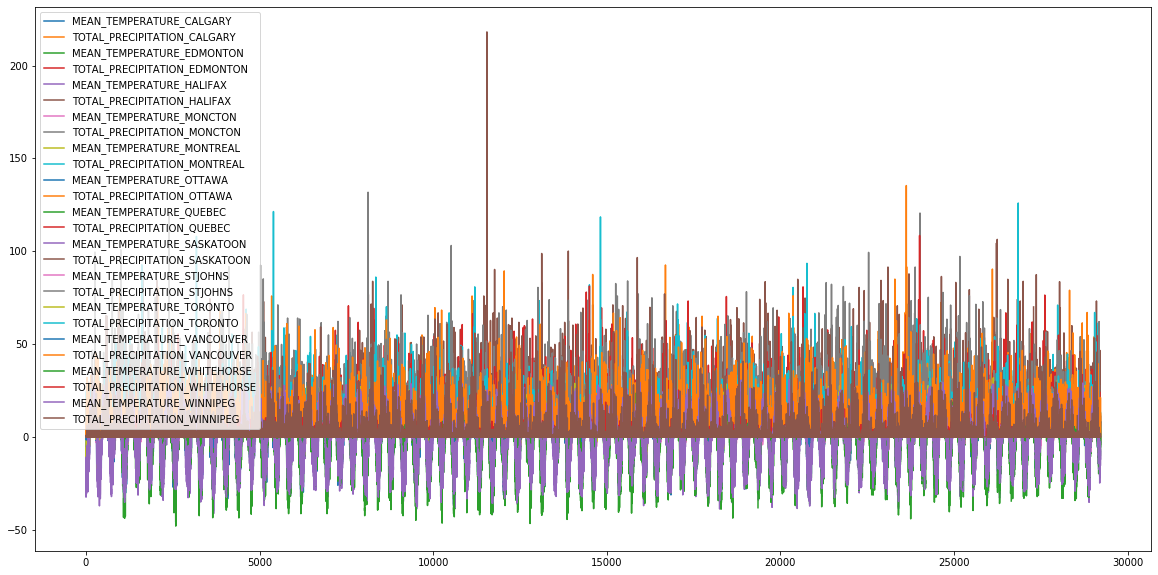

In [6]:
## Multivariate data visualization
df.plot(figsize=(20,10))

## 데이터 로드 함수
- 데이터 불러오기
- scaling
- winodw size shaping

In [96]:
## 경로에 맞는 데이터를 불러오고 결측치 대체와 같은 1차 전처리 수행
def read_modulate_data(data_file):
    """
        Data ingestion : Function to read and formulate the data
    """
    data = pd.read_csv(data_file)
    data.fillna(data.mean(), inplace=True)
    df = data.copy()
    data.set_index("LOCAL_DATE", inplace=True)
    data.index = pd.to_datetime(data.index)
    return data, df # df와 data의 차이는 index가 LOCAL_DATE라는 것 말고는 없다.

In [97]:
def data_pre_processing(df):
    """
        Data pre-processing : Function to create data for Model
    """
    try:
        scaled_data = MinMaxScaler(feature_range = (0, 1))
        data_scaled_ = scaled_data.fit_transform(df)
        df.loc[:,:] = data_scaled_
        _data_ = df.to_numpy(copy=True)
        X = np.zeros(shape=(df.shape[0]-LOOKBACK_SIZE,LOOKBACK_SIZE,df.shape[1]))
        Y = np.zeros(shape=(df.shape[0]-LOOKBACK_SIZE,df.shape[1]))
        timesteps = []
        ## LOOKBACK_SIZE가 10이기에 0~9를 X로 두고 10번 째 값(_data_[9+1])이 첫 번째 Y값이 된다.
        for i in range(LOOKBACK_SIZE-1, df.shape[0]-1):
            timesteps.append(df.index[i])
            # print(f'############## {i}')
            # print('y-step :', i-LOOKBACK_SIZE+1)
            # print(_data_[i+1])
            # print()
            Y[i-LOOKBACK_SIZE+1] = _data_[i+1] # 첫 번째 i=9

            ## LOOKBACK_SIZE만큼 x값을 채운다
            for j in range(i-LOOKBACK_SIZE+1, i+1):
                # print(f'##### {j}')
                # print('y-step :', i-LOOKBACK_SIZE+1)
                # print('x-step :', LOOKBACK_SIZE-1-i+j)
                # print(_data_[j])
                # 첫 배치부터 window size만큼의 값을 채우기 시작한다.
                X[i-LOOKBACK_SIZE+1][LOOKBACK_SIZE-1-i+j] = _data_[j] # X[0][0] = 26으로 변수의 개수
        return X,Y,timesteps
    except Exception as e:
        print("Error while performing data pre-processing : {0}".format(e))
        return None, None, None

### 데이터 관련 함수 test

In [98]:
"""read_modulate_data"""
## 테스트
data, df = read_modulate_data("Canadian_climate_history.csv")

c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  import sys


In [99]:
"""data_pre_processing step 1"""
    # 중간까지의 과정
scaled_data = MinMaxScaler(feature_range = (0, 1))
data_scaled_ = scaled_data.fit_transform(data) # read_modulate_data에서 전처리한 데이터를 사용
data.loc[:, :] = data_scaled_
_data_ = data.to_numpy(copy=True)


## 정규화 안 한 경우
_data_ = data.to_numpy(copy=True)
_data_

array([[0.40973312, 0.00539957, 0.65819212, ..., 0.01625341, 0.25467626,
        0.        ],
       [0.40031397, 0.00539957, 0.65819212, ..., 0.01625341, 0.29064748,
        0.        ],
       [0.40031397, 0.01079914, 0.65819212, ..., 0.01625341, 0.23884892,
        0.        ],
       ...,
       [0.56357928, 0.        , 0.46564885, ..., 0.01625341, 0.39856115,
        0.00119332],
       [0.65620094, 0.        , 0.58320611, ..., 0.01625341, 0.37841727,
        0.        ],
       [0.58398744, 0.        , 0.56183206, ..., 0.01625341, 0.45467626,
        0.        ]])

In [100]:
"""data_pre_processing step 2"""
LOOKBACK_SIZE = 10 # window size
## [full batch size, window_size, feature size] -> 나중에 바뀜
X = np.zeros(shape=(_data_.shape[0]-LOOKBACK_SIZE,LOOKBACK_SIZE,_data_.shape[1]))
Y = np.zeros(shape=(_data_.shape[0]-LOOKBACK_SIZE,_data_.shape[1]))
print('X.shape :', X.shape)
print('Y.shape :', Y.shape)

X.shape : (29211, 10, 26)
Y.shape : (29211, 26)


In [101]:
"""data_pre_processing step 3"""
timesteps = []
for i in range(LOOKBACK_SIZE-1, df.shape[0]-1):
    timesteps.append(df.index[i])
    Y[i-LOOKBACK_SIZE+1] = _data_[i+1]
    for j in range(i-LOOKBACK_SIZE+1, i+1):
        X[i-LOOKBACK_SIZE+1][LOOKBACK_SIZE-1-i+j] = _data_[j]

In [103]:
"""data_pre_processing step 3 확인"""
## X[1] 마지막 값이 Y[0](첫 번째 window의 정답)이 된다.
X[1][-1] == Y[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

## 모델 정의
- DeepAnt 모델 정의
- LSTMAE skip

![](2022-10-11-21-43-40.png)

In [104]:
"""첫 번째 모델"""
## 1D-CNN에서 channel은 feature를 의미
class DeepAnT(torch.nn.Module):
    """
        Model : Class for DeepAnT model
    """
    def __init__(self, LOOKBACK_SIZE, DIMENSION):
        super(DeepAnT, self).__init__()
        # Conv1d layer
        self.conv1d_1_layer = torch.nn.Conv1d(in_channels=DIMENSION, out_channels=32, padding =1, kernel_size=3)
        self.relu_1_layer = torch.nn.ReLU()
        self.maxpooling_1_layer = torch.nn.MaxPool1d(kernel_size=2)
        # Conv1d layer
        self.conv1d_2_layer = torch.nn.Conv1d(in_channels=32, out_channels=64, padding =1, kernel_size=3)
        self.relu_2_layer = torch.nn.ReLU()
        self.maxpooling_2_layer = torch.nn.MaxPool1d(kernel_size=2)
        self.flatten_layer = torch.nn.Flatten()
        # Linear first
        self.dense_1_layer = torch.nn.Linear(128, 40)
        self.relu_3_layer = torch.nn.ReLU()
        self.dropout_layer = torch.nn.Dropout(p=0.25)
        # Linear second
        self.dense_2_layer = torch.nn.Linear(40, DIMENSION)
        
    def forward(self, x):
        x = self.conv1d_1_layer(x)
        x = self.relu_1_layer(x)
        x = self.maxpooling_1_layer(x)
        x = self.conv1d_2_layer(x)
        x = self.relu_2_layer(x)
        x = self.maxpooling_2_layer(x)
        x = self.flatten_layer(x)
        x = self.dense_1_layer(x)
        x = self.relu_3_layer(x)
        x = self.dropout_layer(x)
        return self.dense_2_layer(x)

In [105]:
"""두 번째 모델"""
# class LSTMAE(torch.nn.Module):
#     """
#         Model : Class for LSTMAE model
#     """
#     def __init__(self, LOOKBACK_SIZE, DIMENSION):
#         super(LSTMAE, self).__init__()
#         self.lstm_1_layer = torch.nn.LSTM(DIMENSION, 128, 1)
#         self.dropout_1_layer = torch.nn.Dropout(p=0.2)
#         self.lstm_2_layer = torch.nn.LSTM(128, 64, 1)
#         self.dropout_2_layer = torch.nn.Dropout(p=0.2)
#         self.lstm_3_layer = torch.nn.LSTM(64, 64, 1)
#         self.dropout_3_layer = torch.nn.Dropout(p=0.2)
#         self.lstm_4_layer = torch.nn.LSTM(64, 128, 1)
#         self.dropout_4_layer = torch.nn.Dropout(p=0.2)
#         self.linear_layer = torch.nn.Linear(128, DIMENSION)
        
#     def forward(self, x):
#         x, (_,_) = self.lstm_1_layer(x)
#         x = self.dropout_1_layer(x)
#         x, (_,_) = self.lstm_2_layer(x)
#         x = self.dropout_2_layer(x)
#         x, (_,_) = self.lstm_3_layer(x)
#         x = self.dropout_3_layer(x)
#         x, (_,_) = self.lstm_4_layer(x)
#         x = self.dropout_4_layer(x)
#         return self.linear_layer(x)

'두 번째 모델'

In [106]:
def make_train_step(model, loss_fn, optimizer):
    """
        Computation : Function to make batch size data iterator
    """
    def train_step(x, y):
        model.train()
        yhat = model(x) # 모델 예측값
        loss = loss_fn(y, yhat) # 손실함수 적용
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step ## 함수를 반환

In [110]:
def compute(X,Y):
    """
        Computation : Find Anomaly using model based computation 
    """
    if str(MODEL_SELECTED) == "lstmae":
        ## LSTMAE 부분은 생략
        # model = LSTMAE(10,26)
        # criterion = torch.nn.MSELoss(reduction='mean')
        # optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
        # train_data = torch.utils.data.TensorDataset(torch.tensor(X.astype(np.float32)), torch.tensor(X.astype(np.float32)))
        # train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=False)
        # train_step = make_train_step(model, criterion, optimizer)
        # for epoch in range(30):
        #     loss_sum = 0.0
        #     ctr = 0
        #     for x_batch, y_batch in train_loader:
        #         loss_train = train_step(x_batch, y_batch)
        #         loss_sum += loss_train
        #         ctr += 1
        #     print("Training Loss: {0} - Epoch: {1}".format(float(loss_sum/ctr), epoch+1))
        # hypothesis = model(torch.tensor(X.astype(np.float32))).detach().numpy()
        # loss = np.linalg.norm(hypothesis - X, axis=(1,2))
        # return loss.reshape(len(loss),1)
        return None
    elif str(MODEL_SELECTED) == "deepant":
        model = DeepAnT(LOOKBACK_SIZE = 10,DIMENSION = 26)
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-5)
        # transpose로 차원 바꾸기
            # [batch_size, window, feature] -> [batch_size, feature, window]로 바꾸기
        train_data = torch.utils.data.TensorDataset(torch.tensor(X.astype(np.float32)).transpose(1,2), torch.tensor(Y.astype(np.float32)))
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=False)
        train_step = make_train_step(model, criterion, optimizer) # train_step은 함수를 의미한다.
        for epoch in range(30):
            loss_sum = 0.0
            ctr = 0
            ## batch별 최적화 적용
            for x_batch, y_batch in train_loader:
                loss_train = train_step(x_batch, y_batch) # loss 값 반환
                loss_sum += loss_train # 총 loss 값
                ctr += 1
            print("Training Loss: {0} - Epoch: {1}".format(float(loss_sum/ctr), epoch+1))
        ## 가설: [예측값-실제값]에 대해서 맨허튼 거리를 계산한다.
        hypothesis = model(torch.tensor(X.astype(np.float32)).transpose(1,2)).detach().numpy()
        loss = np.linalg.norm(hypothesis - Y, axis=1) # norm 구하기 (L1 norm : 각 성분의 절대값 더히기)
        return loss.reshape(len(loss),1)
    else:
        print("Selection of Model is not in the set")
        return None

In [111]:
Y.shape

(29211, 26)

In [112]:
data, _data = read_modulate_data(data_file)
X,Y,T = data_pre_processing(data)
loss = compute(X, Y)

c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  import sys


Training Loss: 0.16707617545914547 - Epoch: 1
Training Loss: 0.06946786745631943 - Epoch: 2
Training Loss: 0.042719091506020004 - Epoch: 3
Training Loss: 0.03347400650239232 - Epoch: 4
Training Loss: 0.028009888748684236 - Epoch: 5
Training Loss: 0.024186690941836526 - Epoch: 6
Training Loss: 0.021493581157312334 - Epoch: 7
Training Loss: 0.019176705068167044 - Epoch: 8
Training Loss: 0.017509922026151634 - Epoch: 9
Training Loss: 0.01612042461961573 - Epoch: 10
Training Loss: 0.01493642358303168 - Epoch: 11
Training Loss: 0.014024342129747552 - Epoch: 12
Training Loss: 0.013247971610152872 - Epoch: 13
Training Loss: 0.012568947003270945 - Epoch: 14
Training Loss: 0.012039272910798007 - Epoch: 15
Training Loss: 0.011536182700539046 - Epoch: 16
Training Loss: 0.011139309884998682 - Epoch: 17
Training Loss: 0.010745215218979354 - Epoch: 18
Training Loss: 0.010451198280110612 - Epoch: 19
Training Loss: 0.010175579798745496 - Epoch: 20
Training Loss: 0.009809576868011259 - Epoch: 21
Traini

#### 모델 정의 및 최적화 과정 test

In [113]:
## 모델 확인
data, _data = read_modulate_data(data_file)
X,Y,T = data_pre_processing(data) # T = Timestamp

# 모델 정의
model = DeepAnT(LOOKBACK_SIZE = 10,DIMENSION = 26)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-5)

c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  import sys


In [114]:
## window 마다 (X,Y)의 형태로 묶어주는 것
    # [batch_size, window, feature] -> [batch_size, feature, window]로 바꾸기
    # 1D CNN에 넣기 위함 -> 위에서 transpose를 하지 않으면 window가 channel이 되어버림
train_data = torch.utils.data.TensorDataset(torch.tensor(X.astype(np.float32)).transpose(1,2), torch.tensor(Y.astype(np.float32)))
train_data[0][0].shape # Dimension에 대해 window size만큼 X값이 들어있음

torch.Size([26, 10])

In [115]:
## batch_size가 하나인 것을 32로 바꾸어 주기
    # [29211, feature_size, window_size] => [32, feature_size, window_size]
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=False)
for idx in train_loader:
    # 첫 번째 batch
    x_data = idx[0]
    y_data= idx[1]
    break

# 첫 번째 batch의 형태
print('바뀐 batch_size :', x_data.shape)

바뀐 batch_size : torch.Size([32, 26, 10])


In [116]:
## DeepAnt layer 확인
LOOKBACK_SIZE = 10
DIMENSION = 26
# Conv1d layer
conv1d_1_layer = torch.nn.Conv1d(in_channels=DIMENSION, out_channels=32, padding =1, kernel_size=3)
relu_1_layer = torch.nn.ReLU()
maxpooling_1_layer = torch.nn.MaxPool1d(kernel_size=2)
# Conv1d layer
conv1d_2_layer = torch.nn.Conv1d(in_channels=32, out_channels=64, padding =1, kernel_size=3)
relu_2_layer = torch.nn.ReLU()
maxpooling_2_layer = torch.nn.MaxPool1d(kernel_size=2)
flatten_layer = torch.nn.Flatten()
# Linear first
dense_1_layer = torch.nn.Linear(128, 40)
relu_3_layer = torch.nn.ReLU()
dropout_layer = torch.nn.Dropout(p=0.25)
# Linear second
dense_2_layer = torch.nn.Linear(40, DIMENSION)

In [117]:
x_data.transpose(1,2).shape

torch.Size([32, 10, 26])

In [119]:
print('out1.shape :', out1.shape)
out2 = conv1d_2_layer(out1)
print('두 번째 Conv layer :', out2.shape)
out2 = maxpooling_2_layer(out2)
print('두 번째 pooling layer :', out2.shape)
out2 = flatten_layer(out2)
print('두 번째 flatten 최종 :', out2.shape)

out1.shape : torch.Size([32, 32, 5])
두 번째 Conv layer : torch.Size([32, 64, 5])
두 번째 pooling layer : torch.Size([32, 64, 2])
두 번째 flatten 최종 : torch.Size([32, 128])


-----

## 실행 결과

In [120]:
# batch 만큼의 loss값 (예측값과 실제값 간의 맨해튼 거리)
loss.shape

(29211, 1)

In [121]:
loss_df = pd.DataFrame(loss, columns = ["loss"])
loss_df.index = T # 아까 저장한 timestamp를 저장
loss_df.index = pd.to_datetime(loss_df.index)
loss_df["timestamp"] = T
loss_df["timestamp"] = pd.to_datetime(loss_df["timestamp"])

In [122]:
loss_df.head()

,loss,timestamp
1940-01-10,0.505353,1940-01-10
1940-01-11,0.493965,1940-01-11
1940-01-12,0.343821,1940-01-12
1940-01-13,0.591834,1940-01-13
1940-01-14,0.659072,1940-01-14


c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\RohSeungChan\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\RohSeungChan\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\RohSeungChan\

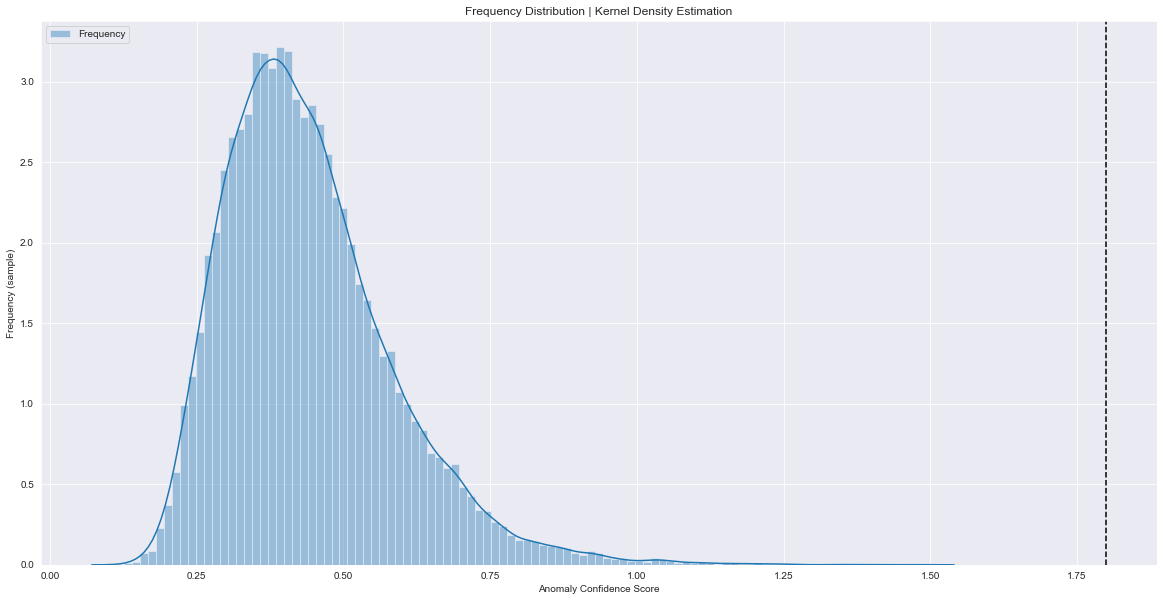

In [123]:
""" Visualization """
## kde 시각화
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
ax = sns.distplot(loss_df["loss"], bins=100, label="Frequency")
ax.set_title("Frequency Distribution | Kernel Density Estimation")
ax.set(xlabel='Anomaly Confidence Score', ylabel='Frequency (sample)')
plt.axvline(1.80, color="k", linestyle="--")
plt.legend()

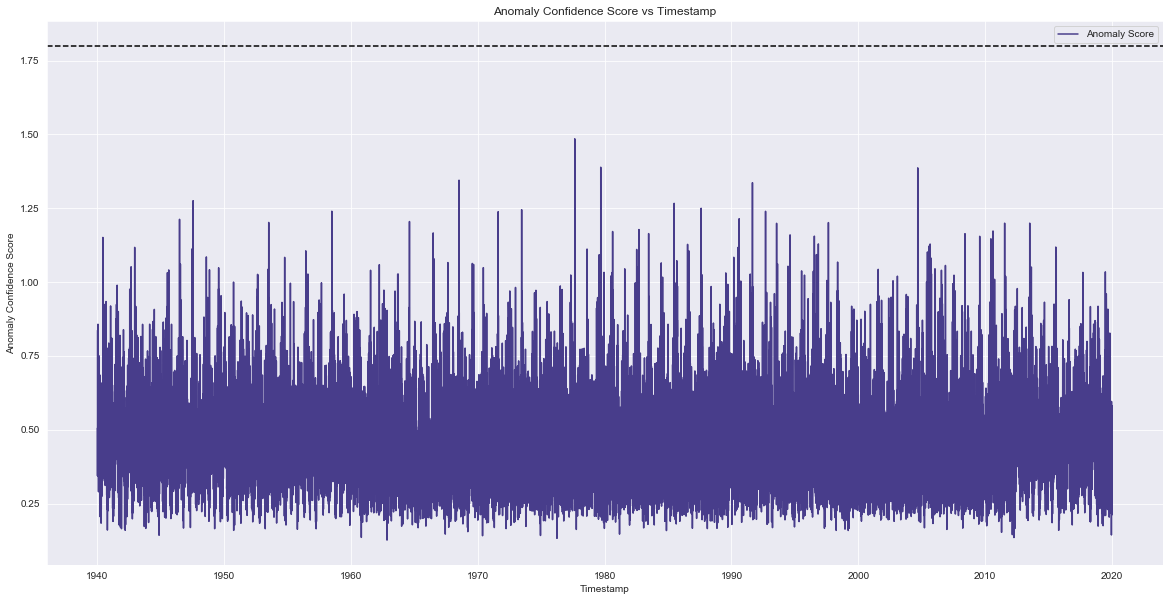

In [124]:
## anomaly score plot
plt.figure(figsize=(20,10))
ax = sns.lineplot(x="timestamp", y="loss", data=loss_df, color='darkslateblue', label="Anomaly Score")
ax.set_title("Anomaly Confidence Score vs Timestamp")
ax.set(ylabel="Anomaly Confidence Score", xlabel="Timestamp")
plt.axhline(1.80, color="k", linestyle="--")
plt.legend()

In [27]:
loss_df

,loss,timestamp
1940-01-10,0.508490,1940-01-10
1940-01-11,0.509528,1940-01-11
1940-01-12,0.330111,1940-01-12
1940-01-13,0.610469,1940-01-13
1940-01-14,0.703127,1940-01-14
...,...,...
2019-12-27,0.306002,2019-12-27
2019-12-28,0.296921,2019-12-28
2019-12-29,0.342601,2019-12-29
2019-12-30,0.322184,2019-12-30
